In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys

sys.path.append("..")

In [11]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm

# tf.autograph.set_verbosity(0)
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
import models.models_neural_networks as nn
import models.models_classic_ml as cm
from data.create_datasets import WindowGenerator

In [13]:
df = pd.read_csv('../datasets/df_feat_enged')
data_name = "weather"

In [14]:
# df.set_index('datetime', inplace=True) 

In [15]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,-1.776611e-12,1.000000,0.009332,0.999956
1,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,2.588190e-01,0.965926,0.010049,0.999950
2,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,5.000000e-01,0.866025,0.010766,0.999942
3,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,7.071068e-01,0.707107,0.011483,0.999934
4,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,8.660254e-01,0.500000,0.012199,0.999926


### plot acf/pacf

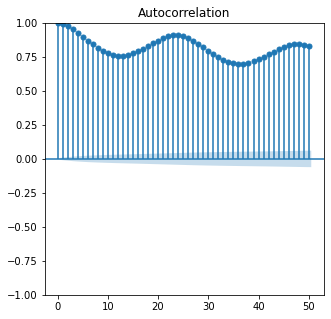

In [16]:
# looking at autocorrelations to find the best window size
plt.rcParams["figure.figsize"] = (5, 5)
sm.graphics.tsa.plot_acf(df['Tpot (K)'], lags=50)
plt.show()

In [17]:
# split data
n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

In [18]:
# Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
train_df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [20]:
window = WindowGenerator(
    label_width=15,
    input_width=24,
    feature_columns= ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)'],
    label_columns= ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)'],
    shift=15,
)

In [21]:
window

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Label column name(s): ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)']
Feature column name (s): ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)']

In [22]:
# create datasets from the dataframes
inputs_train, labels_train = window.create_dataset(train_df)
inputs_val, labels_val = window.create_dataset(val_df)
inputs_test, labels_test = window.create_dataset(test_df)

### Classic ML models

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor

In [4]:
# the parameters of the models are the best ones from a quick grid search 
# test_set_metrics is a dict to keep the metrics of all models
test_set_metrics = {}

models = [LinearRegression(), KNeighborsRegressor(n_neighbors=7), 
          ensemble.ExtraTreesRegressor(max_depth=3, n_estimators=500)]
models_names = ['LRegression','KNNeighbor','ExtraT'] 

In [51]:
for name, model in zip(models_names, models):
    
    model.fit(cm.in_reshape(inputs_train), cm.in_reshape(labels_train))  
    test_set_metrics[name] = (mean_squared_error(
    labels_test.flatten(), model.predict(cm.in_reshape(inputs_test)).flatten()), 
    mean_absolute_error(
    labels_test.flatten(), model.predict(cm.in_reshape(inputs_test)).flatten()))

### Naive model

In [52]:
model_n = "naive"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), nn.naive_model(window, inputs_test, labels_test).flatten()
), mean_absolute_error(
    labels_test.flatten(), nn.naive_model(window, inputs_test, labels_test).flatten()
)


### Dense

In [53]:
tf.keras.backend.clear_session()

In [54]:
model = nn.dense_model(window, units=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()

In [55]:
model_n = "dense_model"
n_trainable_params = {}
history_set = {}
test_set_metrics["dense_vec"] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
), mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)


history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Conv: flexible input/output

In [56]:
model = nn.conv_flex_model(window=window, filters=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()


model_n = "conv_flex_model"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
),mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)
history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Conv: recursive training

In [57]:
model = nn.conv_model_recursive_train(window=window, filters=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()

model_n = "conv_recursive_t"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
),mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)
history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### LSTM: simple 

In [58]:
model = nn.LSTM_model(window=window, units=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()

model_n = "LSTM_model"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
),mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)
history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### LSTM: lambda layer 

In [59]:
## lambda layer
model = nn.LSTM_lambda_layer(window=window, units=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()

model_n = "LSTM_lambda"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
),mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)
history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### LSTM: encoder-decoder

In [60]:
model = nn.LSTM_model_encoder_decoder(window=window, encoder_units=10, decoder_units=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()

model_n = "LSTM_en_de"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
), mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)
history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### LSTM: recursive training

In [61]:
model = nn.LSTM_model_recursive_train(window=window, units=10)

history = nn.compile_and_fit(
    model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val
)

IPython.display.clear_output()


model_n = "LSTM_recursive_t"

test_set_metrics[model_n] = mean_squared_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
), mean_absolute_error(
    labels_test.flatten(), model.predict(inputs_test).flatten()
)
history_set[model_n] = history
n_trainable_params[model_n] = np.sum(
    [np.prod(v.shape) for v in model.trainable_variables]
)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Analytics

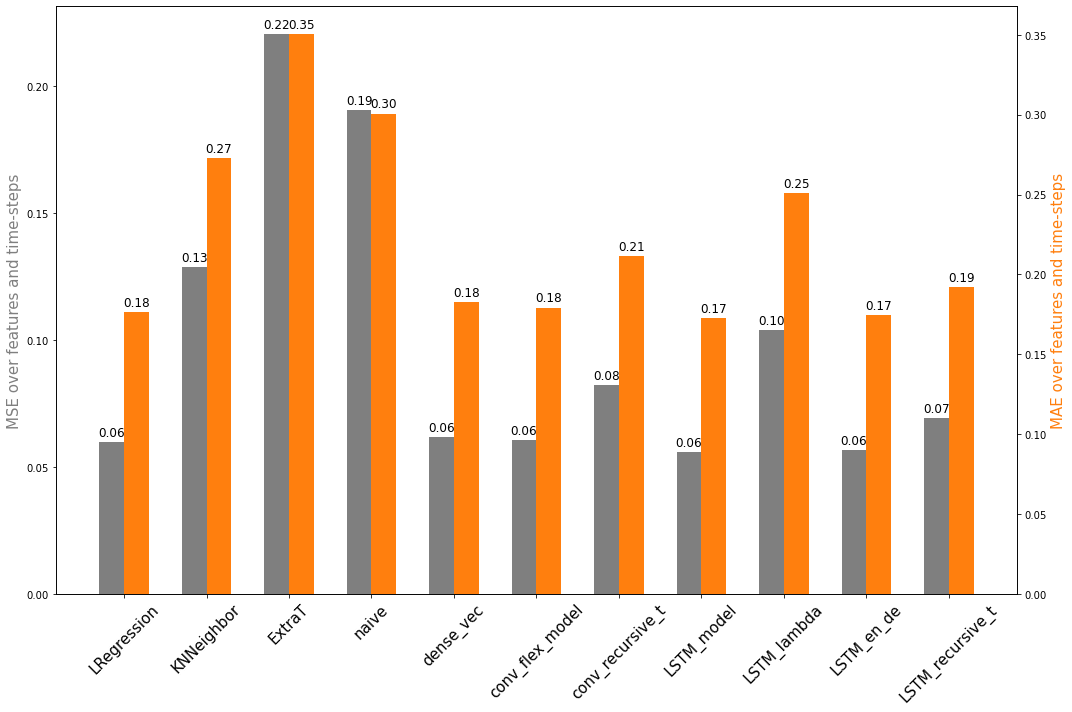

In [62]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False


fig, ax1 = plt.subplots()

x = np.arange(len(test_set_metrics))
width = 0.3

color = "tab:gray"
ax1.set_ylabel("MSE over features and time-steps", color=color, fontsize=15)
ax1.bar(x- width/2 , [i[0] for i in test_set_metrics.values()], width, color=color)
ax1.bar_label(ax1.containers[0],fmt='%.2f', fontsize=12, padding=3)
ax1.set_xticks(ticks=x)
ax1.set_xticklabels(labels=test_set_metrics.keys(), fontsize=15)
ax1.xaxis.set_tick_params(rotation=45)

ax2 = ax1.twinx()

color = "tab:orange"
ax2.set_ylabel("MAE over features and time-steps", color=color, fontsize=15)
width = 0.3
ax2.bar(x + width/2, [i[1] for i in test_set_metrics.values()], width, color=color)
ax2.bar_label(ax2.containers[0],fmt='%.2f', fontsize=12, padding=3)
fig.tight_layout()
plt.savefig(data_name +'.pdf', dpi=fig.dpi)
plt.show()


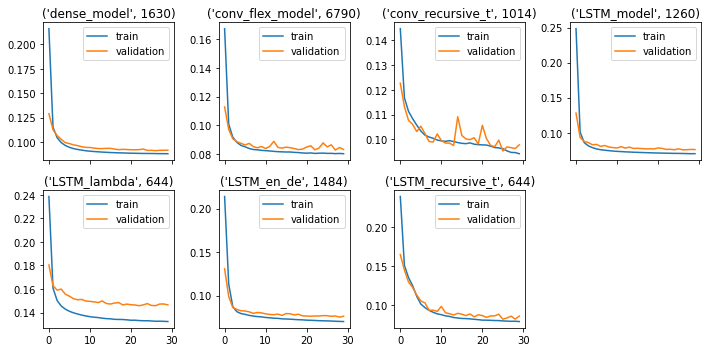

In [63]:
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(10, 5))
axes = axes.ravel()

for i, (key, value) in enumerate(history_set.items()):

    axes[i].plot(history_set[key].history["loss"], label="train")
    axes[i].plot(history_set[key].history["val_loss"], label="validation")
    axes[i].set(title=(key,n_trainable_params[key]))
    
    axes[i].legend()

plt.tight_layout()
axes[7].set_axis_off()


### Vector output:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


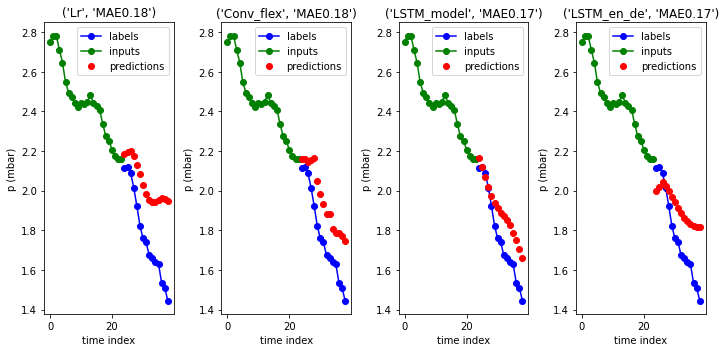

In [25]:
models = [LinearRegression(), nn.conv_flex_model, nn.LSTM_model, nn.LSTM_model_encoder_decoder]
models_n = ['Lr', 'Conv_flex','LSTM_model','LSTM_en_de']

fig, axes = plt.subplots(1, len(models), sharex=True, figsize=(10, 5))
axes = axes.ravel()

for i in range(len(models)):  
    
    if models_n[i] == 'Lr':
        lr_model = models[i].fit(cm.in_reshape(inputs_train), cm.in_reshape(labels_train))
        preds = cm.out_reshape(lr_model.predict(cm.in_reshape(inputs_test)), window)
        score = np.around(mean_absolute_error(preds.flatten(),labels_test.flatten()), decimals=2)  
        cm.plot_forecast(lr_model, window=window, input_data=inputs_test, label_data= labels_test,
                         plot_col="p (mbar)", ax=axes[i])
        axes[i].set_title((models_n[i], "MAE"+ str(score)))    
     
    else:       
        model = models[i](window=window)
        nn.compile_and_fit(model, X=inputs_train, y=labels_train, val_X=inputs_val, val_y=labels_val)
        IPython.display.clear_output()
        score = np.around(mean_absolute_error(labels_test.flatten(), model.predict(inputs_test).flatten()), decimals=2)      
        nn.plot_forecast(model, window=window, input_data=inputs_test, label_data= labels_test,
                          plot_col="p (mbar)", ax=axes[i])
        axes[i].set_title((models_n[i], "MAE"+ str(score)))

plt.tight_layout()

### Recursive forecast:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


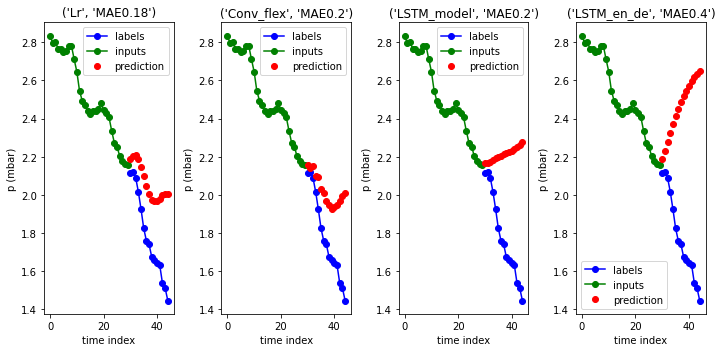

In [26]:
models = [LinearRegression(), nn.conv_flex_model, nn.LSTM_model, nn.LSTM_model_encoder_decoder]
models_n = ['Lr', 'Conv_flex','LSTM_model','LSTM_en_de']

fig, axes = plt.subplots(1, len(models), sharex=True, figsize=(10, 5))
axes = axes.ravel()

for i in range(len(models)):  
    
    print("steps:",i)
    
    if models_n[i] == 'Lr':
        module = cm
    else:
        module = nn
    
    recursive = module.Recursive_Forecast(
    output_time_step=15,
    input_width=30,  
    feature_columns= ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)'],
    label_columns=['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)'],
        )
    recursive.datasets(train_set=train_df, valid_set=val_df, test_set=test_df)
    recursive.model_fit(models[i])
    IPython.display.clear_output()
        
    preds, labels = recursive.recursive_predictions(data="test") 
    
    score = np.around(mean_absolute_error(preds.flatten(),labels.flatten()), decimals=2)    
    
    recursive.plot_forecast_recursive(data="test", plot_col="p (mbar)", ax=axes[i])
    axes[i].set_title((models_n[i], "MAE"+ str(score)))

plt.tight_layout()

### Direct forecast:

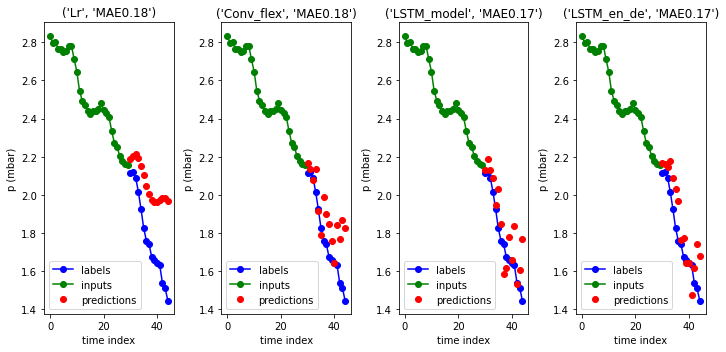

In [27]:
models = [LinearRegression(), nn.conv_flex_model, nn.LSTM_model, nn.LSTM_model_encoder_decoder]
models_n = ['Lr', 'Conv_flex','LSTM_model','LSTM_en_de']


fig, axes = plt.subplots(1, len(models), sharex=True, figsize=(10, 5))
axes = axes.ravel()

for i in range(len(models)):  
    
    print("steps:",i)
    
    if models_n[i] == 'Lr':
        module = cm
    else:
        module = nn        

    direct = module.Direct_Forecast(
     output_time_step=15,
    input_width=30,  
    feature_columns= ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)'],
    label_columns=['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)']
        )
    direct.datasets(train_set=train_df, valid_set=val_df, test_set=test_df)
    direct.model_fit(models[i])
    IPython.display.clear_output()
        
    preds, labels = direct.direct_predictions(data="test")   
    
    score = np.around(mean_absolute_error(preds.flatten(),labels.flatten()), decimals=2) 

    direct.plot_forecast_direct(data="test", plot_col="p (mbar)", ax=axes[i])
    axes[i].set_title((models_n[i], "MAE"+ str(score)))

plt.tight_layout()